# HTGR Micro-Core Quadrant Power

**Input**


- `theta_{1}`: Angle of control drum in quadrant 1 (degrees) 
- `theta_{2}`: Angle of control drum in quadrant 1 (degrees) 
- `theta_{3}`: Angle of control drum in quadrant 2 (degrees)  
- `theta_{4}`: Angle of control drum in quadrant 2 (degrees)
- `theta_{5}`: Angle of control drum in quadrant 3 (degrees)
- `theta_{6}`: Angle of control drum in quadrant 3 (degrees)
- `theta_{7}`: Angle of control drum in quadrant 4 (degrees)  
- `theta_{8}`: Angle of control drum in quadrant 4 (degrees)  



**Output** 

- `FluxQ1` : Neutron flux in quadrant 1 ($\frac{neutrons}{cm^{2} s}$)
- `FluxQ2` : Neutron flux in quadrant 2 ($\frac{neutrons}{cm^{2} s}$)
- `FluxQ3` : Neutron flux in quadrant 3 ($\frac{neutrons}{cm^{2} s}$)
- `FluxQ4` : Neutron flux in quadrant 4 ($\frac{neutrons}{cm^{2} s}$)

The data set consists of about 3000 data points with 8 inputs and 5 outputs. This data set increases in size from about 800 samples to about 3000 samples after producing more data points using reactor symmetries. The data set featured in this work was based around the
HOLOS-Quad reactor design. This reactor implements modular construction where seperate units can be transported independently and assembled at the specified location.  The HOLOS-Quad core is specifically a 22 MWt high-temperature
gas-cooled microreactor (HTGR) which is controlled by 8 cylindrical control drums. It utilizes TRISO fuel particles contained in hexagonal graphite blocks used as a moderator. These graphite blocks have channels where helium gas can pass through for cooling. The image below shows a radial slice of the reactor. [1] 

The main importance of this data set is the influence on the control drums on the neutron flux. The drums control reactivity by rotating to vary the proximity of $B_{4} C$ on a portion of their outer edges to the fueled region of the core. Perturbations of the control drums in tern causes the core power shape to shift leading to complexe power distributions. Therefore, predictions of control drum reactivity worths for arbitrary configurations makes this problem nontrivial. [1] 

Each sample in this dataset has 8 control drum angles where each angle was selected from a uniform random distribution spanning $[-180^\circ, 180^\circ]$ and the corresponding fluxes in each of the four quadrants is calculated using the Serpent code.
The considerably larger dataset is needed because of the larger number of degrees of freedom associated with general statistical models such as deep neural networks (DNN). [1]


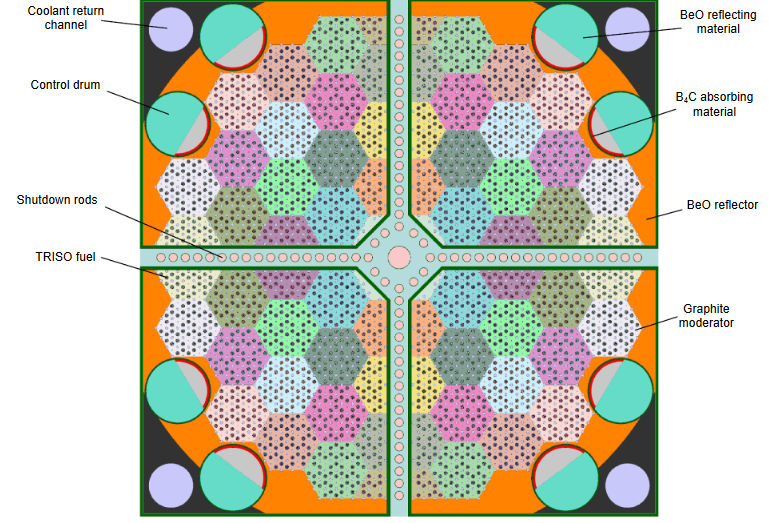

The following are a few common packages and functions that will prove useful while using pyMAISE along with pyMAISE specific functionality. 

In [6]:
# Importing Packages
import time
import cv2
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_HTGR, load_HTGR_preprocessed
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

Using TensorFlow backend


2024-01-13 16:03:26.317155: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:03:26.340655: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:03:26.341574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-13 16:03:26.912561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## pyMAISE Initialization

We first start by initializing pyMAISE settings and then import the data set using `load_HTGR()` from the pyMAISE dataset library.

In [7]:
# Settings 
settings = {
    "verbosity": 0,
    "random_state": 42,
    "test_size": 0.3,
    "num_configs_saved": 5,
    "cuda_visible_devices": "-1", # Use CPUs only
}

# Problem type for a regression, problem = 0
problem_type = mai.ProblemType(0)

# Initializing pyMaise settings
global_settings = mai.settings.init(problem_type=mai.ProblemType.REGRESSION, settings_changes=settings)

# Get data from repoisitory
data, inputs, outputs = load_HTGR()

The data consists of 8 inputs:

In [3]:
inputs

<xarray.DataArray (index: 751, variable: 8)>
array([[5.91952603, 2.36950271, 2.92365595, ..., 4.00890489, 4.97036758,
        2.98796636],
       [2.16238049, 0.273624302, 0.927740883, ..., 0.170166579,
        2.12404792, 4.98020926],
       [0.450100101, 0.006300644, 2.51221749, ..., 3.58225182,
        0.280763918, 4.88859544],
       ...,
       [5.96700387, 5.38006724, 5.20081594, ..., 5.65905406, 5.88623681,
        1.86231118],
       [1.34959071, 1.19391098, 4.65205108, ..., 3.19313598, 5.31477415,
        3.84849236],
       [3.60605462, 5.47085601, 1.75207802, ..., 5.07434654, 2.41128238,
        5.64650044]], dtype=object)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 743 744 745 746 747 748 749 750
  * variable  (variable) object 'theta1' 'theta2' 'theta3' ... 'theta7' 'theta8'

and 4 outputs with 818 samples total. This data set is produced before preprocessing and added more samples using symmetry conditions.

In [4]:
outputs

<xarray.DataArray (index: 751, variable: 4)>
array([[2.58e+19, 2.59e+19, 2.67e+19, 2.56e+19],
       [2.55e+19, 2.53e+19, 2.51e+19, 2.51e+19],
       [2.57e+19, 2.58e+19, 2.52e+19, 2.52e+19],
       ...,
       [2.57e+19, 2.53e+19, 2.52e+19, 2.57e+19],
       [2.64e+19, 2.52e+19, 2.59e+19, 2.61e+19],
       [2.51e+19, 2.55e+19, 2.61e+19, 2.55e+19]], dtype=object)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 743 744 745 746 747 748 749 750
  * variable  (variable) object 'fluxQ1' 'fluxQ2' 'fluxQ3' 'fluxQ4'

The last step for preprocessing the data will be min-max scaling,

In [66]:
# Train test split data
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.30)

# Min-Max scaling data 
xtrain, xtest, _ = scale_data(xtrain, xtest, MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, MinMaxScaler())
data = (xtrain, xtest, ytrain, ytest)

## Model Initialization
As this data set had a multi-dimensional output, we will initialize 6 models:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential Dense Neural Networks: `FNN`.

All the classical models are initialized with the Scikit-learn defaults; however, the neural networks require some paramter definitions for the layers, optimizer, and training.

In [67]:
# Initializing all the models wanted along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=2),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

The classical models are hyper-paramter tunned with random search as they are inexpensive to train and the DNN is trained with Baysian search to limit training time.

In [ ]:
# Classical Model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Search space was not provided for Linear, current parameters will be added


We can understand the hyper-parameter tuning of Bayesian search on the artificial neural network from the convergence plot below.

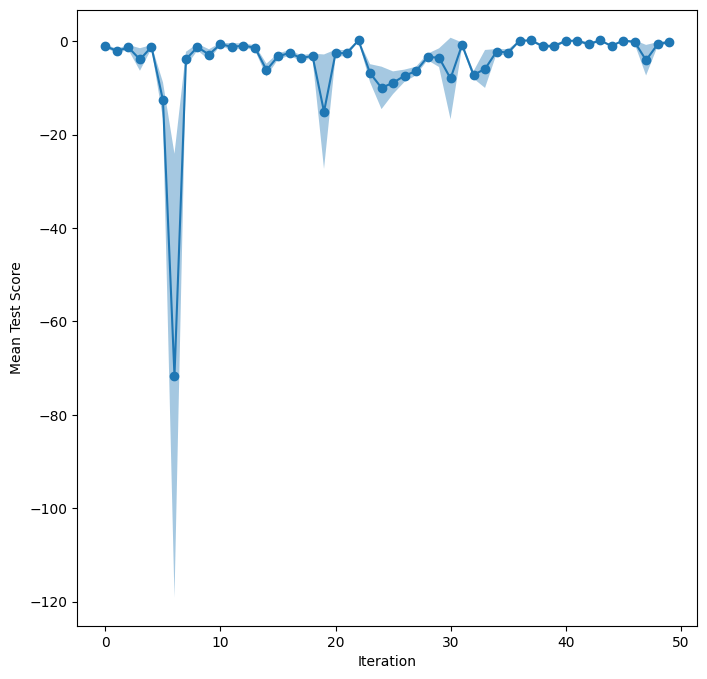

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuner.convergence_plot(model_types="FNN")

## Model Post-processing

With the top `num_configs_saved`, we can pass these parameter configurations to the `PostProcessor` for model comparison and analysis. For `nn` we define the `epochs` parameter to be 200 for better performance.

In [23]:
new_model_settings = {
    "FNN": {
        "fitting_params":{
            "epochs": 200,
        }
    }
}
postprocessor = mai.PostProcessor(
    data=data,
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
    yscaler=yscaler,
)

To compare the performance of these models we will compute performance metrics for both the training and testing data: 


In [24]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,FNN,"{'Dense_input_0_units': 266, 'Dense_input_0_su...",0.811036,1.539707e+17,4.542313e+34,2.131270e+17,0.658664,2.329650e+17,8.227110e+34,2.868294e+17
23,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.837686,1.388502e+17,3.901986e+34,1.975345e+17,0.642774,2.350367e+17,8.578428e+34,2.928895e+17
25,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.837315,1.404271e+17,3.912061e+34,1.977893e+17,0.632676,2.384386e+17,8.861411e+34,2.976812e+17
22,FNN,"{'Dense_input_0_units': 267, 'Dense_input_0_su...",0.876992,1.116513e+17,2.959279e+34,1.720255e+17,0.586079,2.535043e+17,9.976915e+34,3.158625e+17
24,FNN,"{'Dense_input_0_units': 368, 'Dense_input_0_su...",0.874081,1.226054e+17,3.022679e+34,1.738585e+17,0.556576,2.622759e+17,1.070560e+35,3.271942e+17
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.922740,1.083767e+17,1.856404e+34,1.362499e+17,0.476550,2.818274e+17,1.266166e+35,3.558323e+17
14,RF,"{'criterion': 'squared_error', 'max_features':...",0.842614,1.528916e+17,3.782383e+34,1.944835e+17,0.472183,2.832225e+17,1.274565e+35,3.570105e+17
13,RF,"{'criterion': 'squared_error', 'max_features':...",0.843695,1.518966e+17,3.755260e+34,1.937849e+17,0.471976,2.829167e+17,1.274724e+35,3.570328e+17
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.814508,1.672229e+17,4.456436e+34,2.111027e+17,0.465180,2.865208e+17,1.294634e+35,3.598102e+17
15,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.863541,1.428583e+17,3.278402e+34,1.810636e+17,0.463507,2.849273e+17,1.295201e+35,3.598890e+17


From each model we can see poor performance. The significant performer is the DNN which is still not acceptable enough to consider this model for application.

In [25]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.0003725122745286169

Model Types: DT
max_depth: 16
max_features: 6
min_samples_leaf: 10
min_samples_split: 11

Model Types: RF
criterion: absolute_error
max_features: 4
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 107

Model Types: KN
leaf_size: 6
n_neighbors: 11
p: 1
weights: distance

Model Types: FNN
Dense_input_0_units: 266
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.5631923509574992
Dense_hidden_num_layers: 0
Adam_learning_rate: 0.000992776209092695
batch_size: 8
Dense_hidden_0_units: 75
Dense_hidden_0_sublayer: Dropout_hidden
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.2219547285130471
Dense_hidden_1_units: 50
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.47506479467865753



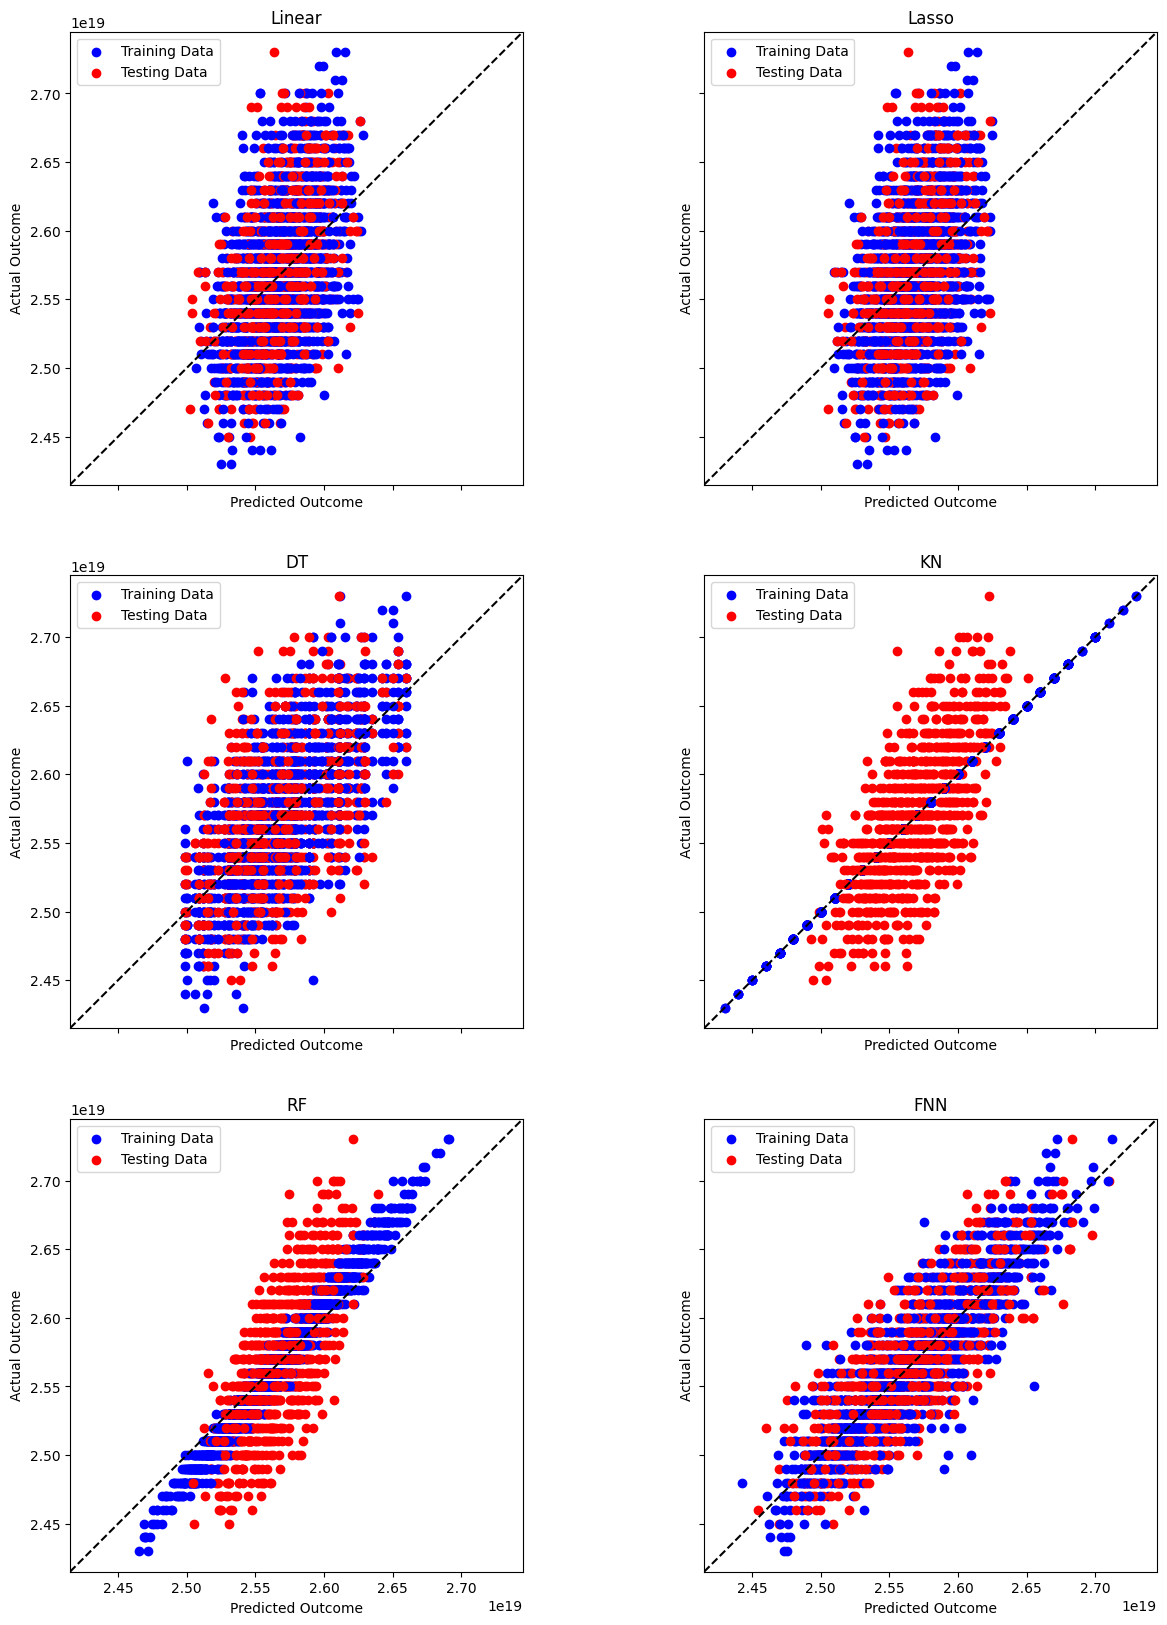

In [26]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

Lastly we can see the `nn` traning curve. Due to loss being higher for validation one can assume this model cannot predict well.

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

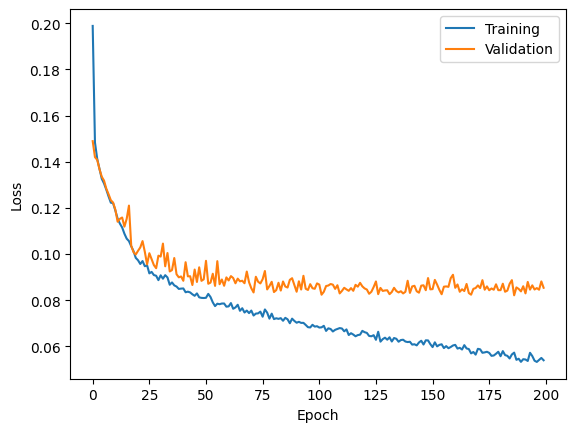

In [27]:
postprocessor.nn_learning_plot()

## Updated data using reactor symmetries to multiply samples

To obtain better results, higher levels of preprocessing is done using the `qpower_preprocessing` function from https://github.com/deanrp2/MicroControl/blob/main/pmdata/. This function applies the symmetry rules to multiply the samples, removes unnecessary columns, adjusts the drum angles to be in the correct cordinate system, and normalizes quadrant powers. This expands the data set from 818 samples to 3004 samples.

Additionally, the `careful_split` function from https://github.com/deanrp2/MicroControl/blob/main/pmdata/ is used to ensure samples deriving from the same sample fall in the same data set during the training and testing split.

## pyMAISE Initialization

The `careful_split` function is used for train/test split [1]. The function definition can be seen below 

In [8]:
def careful_split(df, tstfrac = False, tstnum = False):
    """
    Returns a train and test split which does not allow samples coming from the same calculation
    to exist across the train/test line. In other words, samples generated from symmetry must stay
    with the sample they were made from.

    df: must be dataframe with the indices given from the mult_sym function. make sure to sort_index
    tstfrac: generate the split based on an approximate fraction to include in the TESTING set
    tstnum: generate the split based on an approximate total number to include in the TESTING set. The argument here
        will be approximately the total number of rows in the testing dataframe that is returned
    """
    tot_samples = df.shape[0]

    #determine size of final testing set divided by 4
    if tstnum:
        tstsize = int(tstnum//4)
    elif tstfrac:
        tstsize = int((tot_samples*tstfrac)//4)
    else:
        raise Exception("Please specify tstfrac or tstsize")

    #get sample names associate with original calcs
    samplenums = np.unique([a[:12] for a in df.index])

    #pick a set from the original sample names
    tidxr = list(np.random.choice(samplenums, tstsize, replace = False))

    #expand set to include multiplied sample names as well
    tidxf = sorted(tidxr + [a + "_h" for a in tidxr] + [a + "_r" for a in tidxr] + [a + "_v" for a in tidxr])

    #index original dataframe to get the sets
    train = df.drop(tidxf)
    test = df.loc[tidxf]

    return train, test

This splitting also was produced from https://github.com/deanrp2/MicroControl/blob/main/pmdata/.

In [9]:
#load data
data = pd.read_csv("../../../pyMAISE/datasets/microreactor_preprocessed.csv", index_col = 0)

In [10]:
data

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,fluxQ1,fluxQ2,fluxQ3,fluxQ4
sample_00000,2.237507,-1.698166,2.433453,1.253772,3.140399,-3.082829,2.754851,0.386800,0.248175,0.249199,0.256734,0.245892
sample_00000_h,1.253772,2.433453,-1.698166,2.237507,0.386800,2.754851,-3.082829,3.140399,0.249199,0.248175,0.245892,0.256734
sample_00000_r,-3.140399,3.082829,-2.754851,-0.386800,-2.237507,1.698166,-2.433453,-1.253772,0.256734,0.245892,0.248175,0.249199
sample_00000_v,-0.386800,-2.754851,3.082829,-3.140399,-1.253772,-2.433453,1.698166,-2.237507,0.245892,0.256734,0.249199,0.248175
sample_00001,-1.519638,2.489141,-1.853817,1.147173,-2.058398,0.755909,-0.091469,2.379043,0.252723,0.250798,0.248167,0.248312
...,...,...,...,...,...,...,...,...,...,...,...,...
sample_00817_v,-1.247326,-3.099257,2.267060,-1.909570,-0.263247,-0.705058,2.873758,2.332428,0.251804,0.250008,0.243343,0.254845
sample_00818,-0.075964,1.403187,-2.678154,-0.037988,-1.921514,2.134915,0.195766,3.045334,0.245477,0.249179,0.255498,0.249846
sample_00818_h,-0.037988,-2.678154,1.403187,-0.075964,3.045334,0.195766,2.134915,-1.921514,0.249179,0.245477,0.249846,0.255498
sample_00818_r,1.921514,-2.134915,-0.195766,-3.045334,0.075964,-1.403187,2.678154,0.037988,0.255498,0.249846,0.245477,0.249179


In [11]:
#load data
data = pd.read_csv("../../../pyMAISE/datasets/microreactor_preprocessed.csv", index_col = 0)
#train and test split
train, test = careful_split(df = data, tstfrac = 0.2)

#define predictors and responses
pred = ["theta" + str(i) for i in range(1, 9)]
resp = ["fluxQ"+str(i) for i in range(1,5)]

#split into X/Y data arrays
xtrain=train[pred].values
xtest=test[pred].values

ytrain=train[resp].values
ytest=test[resp].values

print(type(xtrain))
# Putting data back into a pandas data frame for pyMAISE to use
# data = ( 
#     pd.DataFrame(xtrain, columns=['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8']),
#     pd.DataFrame(xtest, columns=['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8']),
#     pd.DataFrame(ytrain, columns=['fluxQ1', 'fluxQ2', 'fluxQ3', 'fluxQ4']),
#     pd.DataFrame(ytest, columns=['fluxQ1', 'fluxQ2', 'fluxQ3', 'fluxQ4'])
# )
# converting to xarray
# Convert each DataFrame to xarray Dataset
print(xtrain.shape)
xtrain = xr.DataArray(xtrain)
ytrain = xr.DataArray(ytrain)
xtest = xr.DataArray(xtest)
ytest = xr.DataArray(ytest)
data = (xtrain, xtest, ytrain, ytest)

<class 'numpy.ndarray'>
(2404, 8)


## Model Initialization

Models were initialized the same as before.

In [12]:
# Initializing all the models wanted in the model)settings variable along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=300),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32, 64]),
            "epochs": 100,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning
The hyperparameter tuning spaces are defined below. Major differences are the slightly expanded search space along with Baysian search have double the amount of iterations and random search producing more models.

In [13]:
# Classical Model search space
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "svr": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

# Running the tuner for with the search algorithm desired
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=100,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")


Trial 100 Complete [00h 01m 57s]
r2_score: 0.920035104259958

Best r2_score So Far: 0.9597869358491543
Total elapsed time: 02h 07m 46s
Hyperparameter tuning took 127.80118592182795 minutes to process.


Once again a plot of the Bayesian search `nn` convergence is shown.

(-5.0, 1.0)

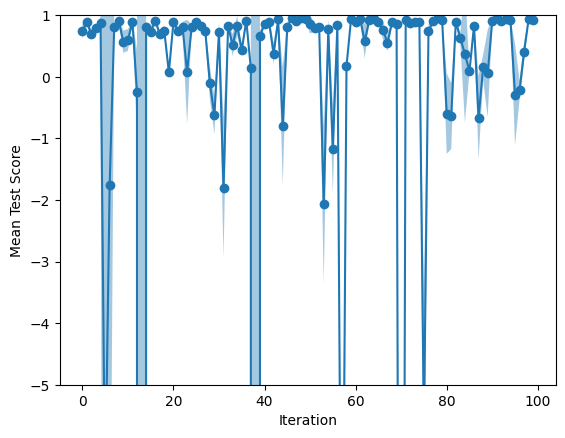

In [26]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([-5, 1])

## Model Post-processing

With the models tuned and the top `num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. We will increase the `epochs` of the `nn` models for better performance.

In [16]:
new_model_settings = {
    "FNN": {
        "fitting_params":{
            "epochs": 200,
        }
    }
}
postprocessor = mai.PostProcessor(
    data=data,
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
)

The averaged performance matrics can be seen below.

In [17]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
6,FNN,"{'Dense_input_0_units': 143, 'Dense_input_0_su...",9.817377e-01,0.000455,3.306454e-07,0.000575,9.778210e-01,0.000464,3.545335e-07,0.000595
9,FNN,"{'Dense_input_0_units': 122, 'Dense_input_0_su...",9.812833e-01,0.000451,3.388737e-07,0.000582,9.764973e-01,0.000478,3.756931e-07,0.000613
5,FNN,"{'Dense_input_0_units': 328, 'Dense_input_0_su...",9.729363e-01,0.000562,4.899989e-07,0.000700,9.701491e-01,0.000554,4.771694e-07,0.000691
8,FNN,"{'Dense_input_0_units': 387, 'Dense_input_0_su...",9.741492e-01,0.000528,4.680396e-07,0.000684,9.646088e-01,0.000589,5.657303e-07,0.000752
7,FNN,"{'Dense_input_0_units': 137, 'Dense_input_0_su...",9.654830e-01,0.000623,6.249433e-07,0.000791,9.598352e-01,0.000639,6.420380e-07,0.000801
3,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",9.678510e-01,0.000608,5.820693e-07,0.000763,7.498743e-01,0.001595,3.998277e-06,0.002000
4,KN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",7.801063e-01,0.001551,3.981261e-06,0.001995,6.887783e-01,0.001745,4.974902e-06,0.002230
2,DT,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1.000000e+00,0.000000,0.000000e+00,0.000000,2.065814e-01,0.002800,1.268285e-05,0.003561
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",9.671910e-03,0.003412,1.793028e-05,0.004234,1.666594e-02,0.003175,1.571867e-05,0.003965
1,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",1.221245e-15,0.003422,1.810539e-05,0.004255,-5.551115e-17,0.003187,1.598507e-05,0.003998


From this we can see that all the models performed significantly better with neural networks doing the best. To visualize this further diagonal validation plots and validations plots were ploduced below.

In [18]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 1.0
copy_X: True
fit_intercept: True
max_iter: 1000
normalize: deprecated
positive: False
precompute: False
random_state: None
selection: cyclic
tol: 0.0001
warm_start: False

Model Types: DT
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best

Model Types: RF
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False

Model Types: KN
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform

Model Types: FNN
Dense_input_0_units: 143
Dense_input_0_sublayer: None
Dense_i

Lastly the neural networks learning curve was produced to show there is no overfitting.

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

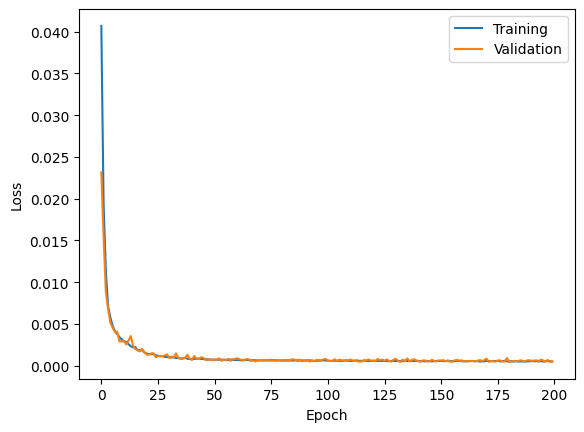

In [19]:
postprocessor.nn_learning_plot()

## References
[1] Price, Dean & Radaideh, Majdi & Kochunas, Brendan. (2022). Multiobjective optimization of nuclear microreactor reactivity control system operation with swarm and evolutionary algorithms. Nuclear Engineering and Design. 393. 111776. 10.1016/j.nucengdes.2022.111776.

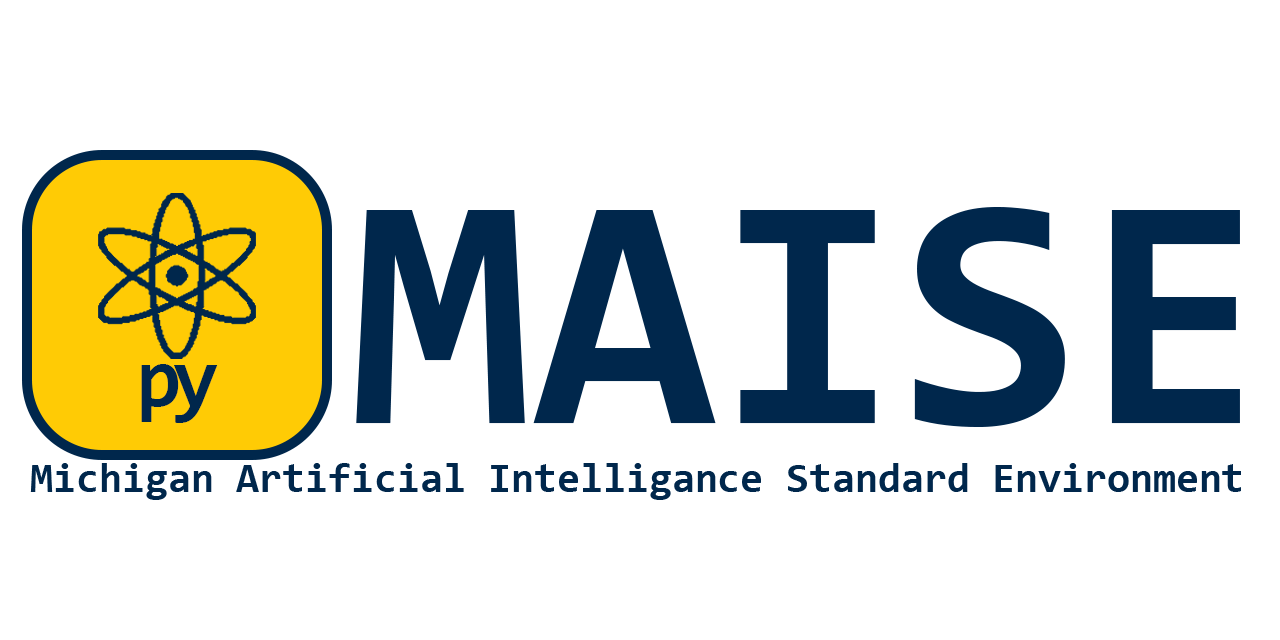